# Author

***Written by Ho Sy The***

Hanoi University of Science and Technology

IT1 04 - K65.

*Github: https://github.com/hsthe29*

- **date: 2022-09-10**

# Implementation

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Input, Conv2D, Conv2DTranspose, Reshape, Flatten
from keras.layers.advanced_activations import LeakyReLU
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.utils import plot_model
from tqdm import tqdm

Source code

In [ ]:
class GAN_model:
  generator = None
  discriminator = None
  f_dim = 200
  BATCH_SIZE = 500

  def __init__(self, summary=False, clear_session=False):
    if clear_session:
      tf.keras.backend.clear_session()
    # generator
    self.generator = Sequential()
    # self.generator.add(Input(shape=(self.f_dim,)))
    self.generator.add(Dense(64*7*7, input_shape=(self.f_dim,), activation=LeakyReLU(alpha=0.2)))
    self.generator.add(Reshape((7, 7, 64)))
    self.generator.add(Conv2DTranspose(64, kernel_size=(3, 3), strides=2, padding='same', activation=LeakyReLU(alpha=0.2)))
    self.generator.add(Conv2DTranspose(32, kernel_size=(3, 3), strides=2, padding='same', activation=LeakyReLU(alpha=0.2)))
    self.generator.add(Conv2DTranspose(16, kernel_size=(3, 3), strides=2, padding='same', activation=LeakyReLU(alpha=0.2)))
    self.generator.add(Conv2D(1, kernel_size=(3, 3), padding='same', strides=(2, 2), activation='sigmoid'))

    adam = Adam(learning_rate=0.0002, beta_1=0.5)
    self.generator.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
    self.generator.summary()
    # discriminator
    self.discriminator = Sequential()
    # self.discriminator.add(Input(shape=(28, 28, 1)))
    self.discriminator.add(Conv2D(filters=16, input_shape=(28, 28, 1), kernel_size=(3,3), padding='same', activation=LeakyReLU(alpha=0.2)))
    self.discriminator.add(Dropout(0.2))
    self.discriminator.add(Conv2D(filters=32, kernel_size=(3,3), strides=(2,2), padding='same', activation=LeakyReLU(alpha=0.2)))
    self.discriminator.add(Conv2D(filters=64, kernel_size=(3,3), strides=(2,2), padding='same', activation=LeakyReLU(alpha=0.2)))
    self.discriminator.add(Flatten())
    self.discriminator.add(Dense(1000, activation=LeakyReLU(alpha=0.2)))
    self.discriminator.add(Dense(200, activation=LeakyReLU(alpha=0.2)))
    self.discriminator.add(Dense(1, activation='sigmoid'))
    self.discriminator.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
    self.discriminator.trainable = False
    
    input = Input(shape=(self.f_dim,))
    output = self.discriminator(self.generator(input))
    self.gan = Model(input, output)
    
    self.gan.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
    if summary:
      self.gan.summary()

  # loss function
  def plot_loss(self):
    d_loss = [v[0] for v in self.losses["D"]]
    g_loss = [v[0] for v in self.losses["G"]]
    plt.figure(figsize=(10,8))
    plt.plot(d_loss, label="Discriminator loss")
    plt.plot(g_loss, label="Generator loss")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
  # plot samples from Generator
  def plot_generated(self, n_ex=10, dim=(1, 10), figsize=(12, 2)):
    noise = np.random.normal(0, 1, size=(n_ex, self.f_dim))
    generated_images = self.generator.predict(noise)
    generated_images = generated_images.reshape(n_ex, 28, 28)
    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
      plt.subplot(dim[0], dim[1], i+1)
      plt.imshow(generated_images[i], interpolation='nearest', cmap='gray_r')
      plt.axis('off')
    plt.tight_layout()
    plt.show()

  def fit(self, X, epochs=1, freq=1, k=2):
    try:
      del self.losses
    except:
      pass
    self.losses = {"D":[], "G":[]}
    batch_count = X.shape[0] // self.BATCH_SIZE
    print('Epochs:', epochs)
    print('Batch size:', self.BATCH_SIZE)
    print('Batches per epoch:', batch_count)
    for ep in tqdm(range(epochs)):
      if ep + 1 == 1 or (ep+1)%freq == 0:
        print('-'*15, 'Epoch %d' % (ep+1), '-'*15)

      for j in range(batch_count):
        if j % k == 0:
          # take real images
          real_data = X[np.random.randint(0, X.shape[0], size=self.BATCH_SIZE)]
          # generate fake image
          noise = np.random.normal(0, 1, size=(self.BATCH_SIZE, self.f_dim))
          fake_data = self.generator.predict(noise)

          X_fit = np.concatenate((real_data, fake_data))
          y = np.zeros(2*self.BATCH_SIZE)
          y[:self.BATCH_SIZE] = 1.0

          self.discriminator.trainable = True
          d_loss = self.discriminator.train_on_batch(X_fit, y)

        # Train generator
        noise = np.random.normal(0, 1, size=(2*self.BATCH_SIZE, self.f_dim))
        y2 = np.ones(2*self.BATCH_SIZE)
        self.discriminator.trainable = False
        g_loss = self.gan.train_on_batch(noise, y2)
      
      self.losses["D"].append(d_loss)
      self.losses["G"].append(g_loss)
      if ep == 0 or (ep+1)%freq == 0:
        self.plot_generated()

    self.plot_loss()

  def generate(self, size=1):
    noise = np.random.randn(size, self.f_dim)
    generated_images = self.generator.predict(noise)
    return generated_images.reshape(size, 28, 28)

  

In [ ]:
def summarize_performance(gan_model, X_real, y_real, X_fake, y_fake):
	_, acc_real = gan_model.discriminator.evaluate(X_real, y_real, verbose=0)
	_, acc_fake = gan_model.discriminator.evaluate(X_fake, y_fake, verbose=0)
	# thống kê discriminator performance
	print('>>> Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))

# Preprocess data

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# x_train = x_train.reshape(-1, 784)
# x_test = x_test.reshape(-1, 784)

x_train = np.expand_dims(x_train, axis=-1)
x_test_normal = np.expand_dims(x_test, axis=-1)

In [ ]:
x_train.shape

(60000, 28, 28, 1)

# Example 1

In [ ]:
model = GAN_model(summary=True, clear_session=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 3136)              630336    
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 64)       36928     
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 32)       18464     
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 56, 56, 16)       4624      
 ranspose)                                                       
                                                        

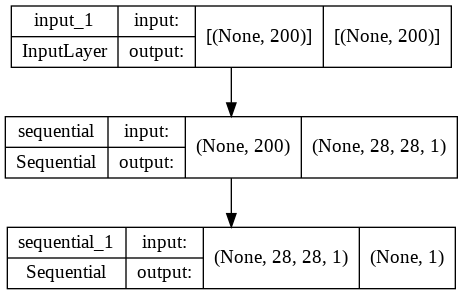

In [ ]:
plot_model(model.gan, show_shapes=True)

Epochs: 100
Batch size: 500
Batches per epoch: 120


  0%|          | 0/100 [00:00<?, ?it/s]

--------------- Epoch 1 ---------------


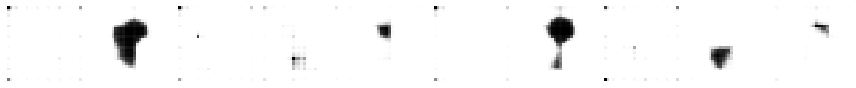

  4%|▍         | 4/100 [01:29<35:25, 22.14s/it]

--------------- Epoch 5 ---------------


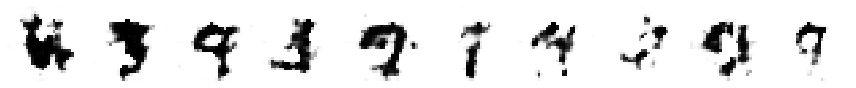

  9%|▉         | 9/100 [03:17<33:01, 21.77s/it]

--------------- Epoch 10 ---------------


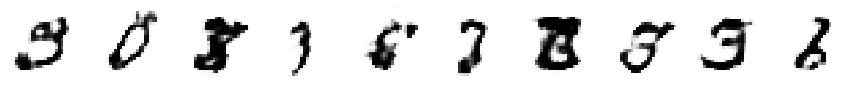

 14%|█▍        | 14/100 [05:07<31:17, 21.83s/it]

--------------- Epoch 15 ---------------


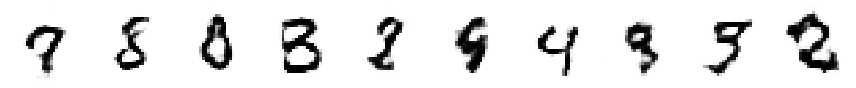

 19%|█▉        | 19/100 [06:55<29:19, 21.72s/it]

--------------- Epoch 20 ---------------


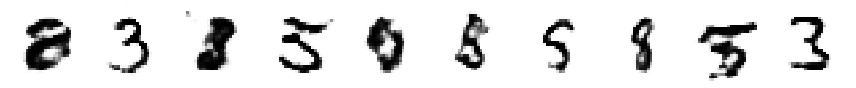

 24%|██▍       | 24/100 [08:44<27:32, 21.74s/it]

--------------- Epoch 25 ---------------


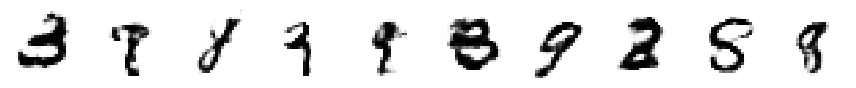

 29%|██▉       | 29/100 [10:31<25:21, 21.43s/it]

--------------- Epoch 30 ---------------


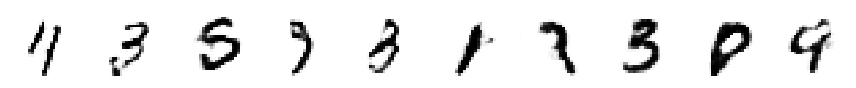

 34%|███▍      | 34/100 [12:19<23:40, 21.52s/it]

--------------- Epoch 35 ---------------


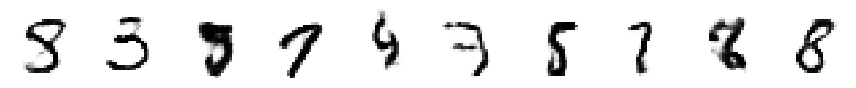

 39%|███▉      | 39/100 [14:07<21:52, 21.52s/it]

--------------- Epoch 40 ---------------


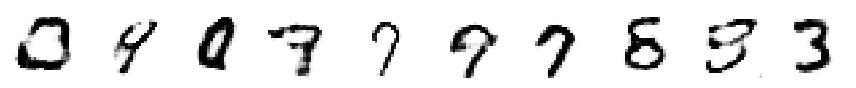

 44%|████▍     | 44/100 [15:54<20:03, 21.50s/it]

--------------- Epoch 45 ---------------


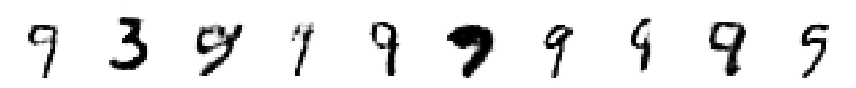

 49%|████▉     | 49/100 [17:42<18:12, 21.43s/it]

--------------- Epoch 50 ---------------


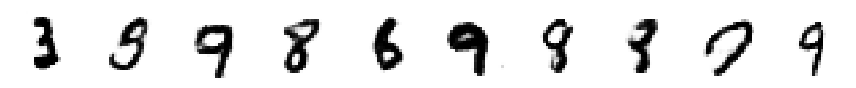

 54%|█████▍    | 54/100 [19:29<16:28, 21.48s/it]

--------------- Epoch 55 ---------------


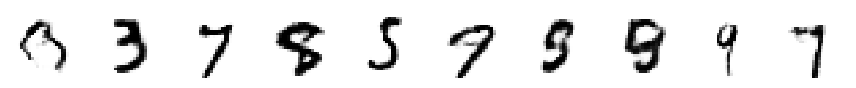

 59%|█████▉    | 59/100 [21:16<14:32, 21.29s/it]

--------------- Epoch 60 ---------------


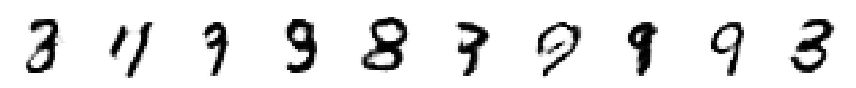

 64%|██████▍   | 64/100 [23:03<12:50, 21.41s/it]

--------------- Epoch 65 ---------------


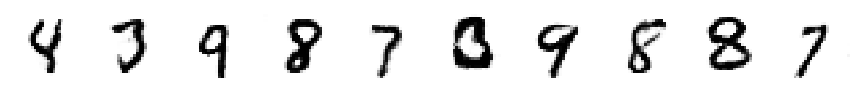

 69%|██████▉   | 69/100 [24:50<11:02, 21.37s/it]

--------------- Epoch 70 ---------------


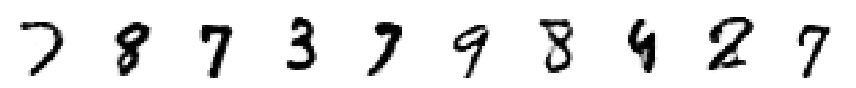

 74%|███████▍  | 74/100 [26:37<09:13, 21.30s/it]

--------------- Epoch 75 ---------------


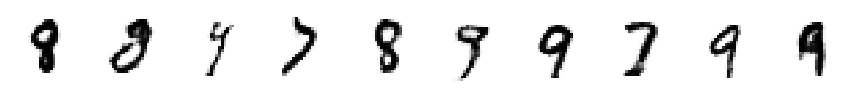

 79%|███████▉  | 79/100 [28:24<07:30, 21.46s/it]

--------------- Epoch 80 ---------------


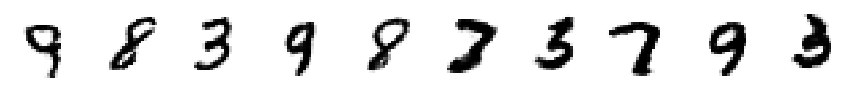

 84%|████████▍ | 84/100 [30:14<05:47, 21.74s/it]

--------------- Epoch 85 ---------------


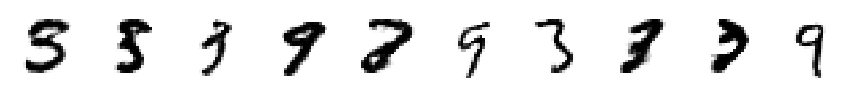

 89%|████████▉ | 89/100 [32:03<03:57, 21.57s/it]

--------------- Epoch 90 ---------------


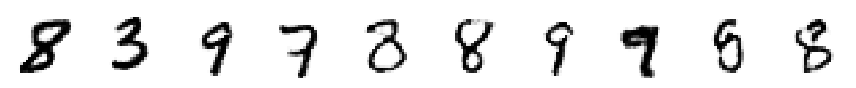

 94%|█████████▍| 94/100 [33:50<02:08, 21.38s/it]

--------------- Epoch 95 ---------------


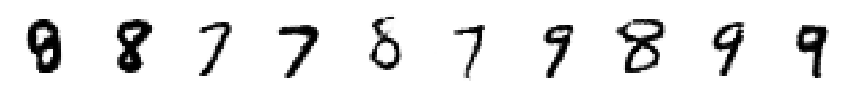

 99%|█████████▉| 99/100 [35:38<00:21, 21.67s/it]

--------------- Epoch 100 ---------------


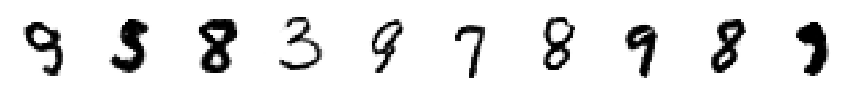

100%|██████████| 100/100 [36:00<00:00, 21.60s/it]


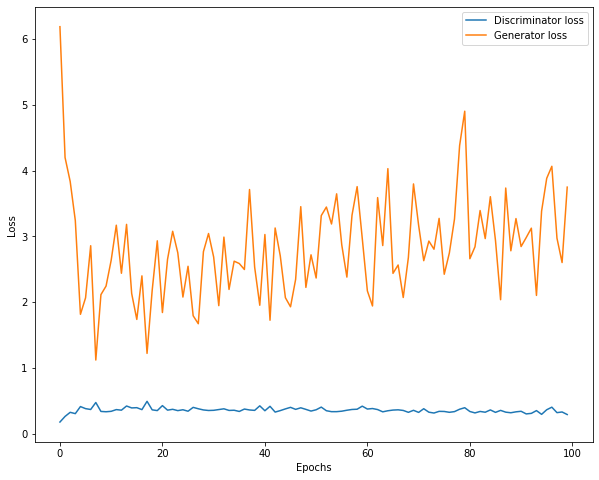

In [ ]:
model.fit(x_train/255, epochs=100, freq=5)

## Evaluate

In [ ]:
# take real images
real_X = x_train[np.random.randint(0, x_train.shape[0], size=500)]
# noise
noise_X = np.random.normal(0, 1, size=(500, 200))
# generate fake image
fake_X = model.generator.predict(noise_X)

y_real = np.ones((500, 1))
y_fake = np.zeros((500, 1))

summarize_performance(model, real_X, y_real, fake_X, y_fake)

>>> Accuracy real: 100%, fake: 98%


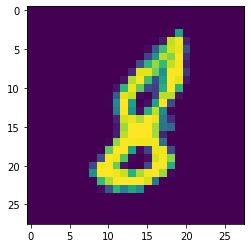

In [ ]:
plt.imshow(fake_X[0].reshape(28, 28))
plt.show()

In [ ]:
inp = Input(shape=(4,), name="inp")
ds = Dense(56, name='ds')(inp)

md = Model(inputs = [inp], outputs = [ds])
aa = Sequential()
aa.add(md)
# aa.build()

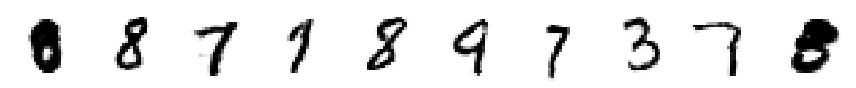

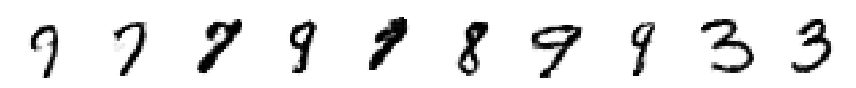

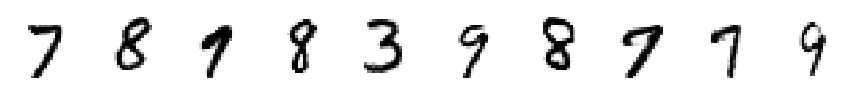

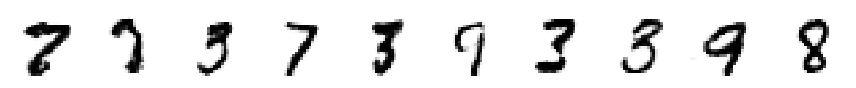

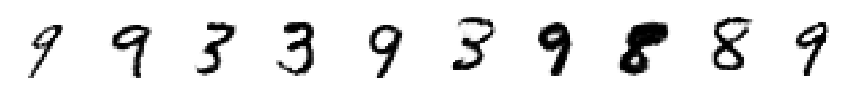

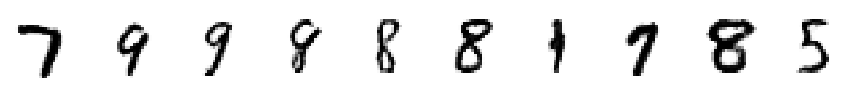

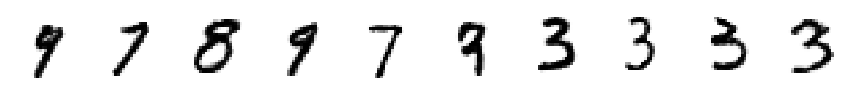

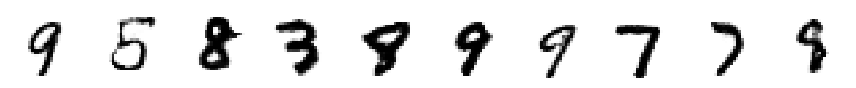

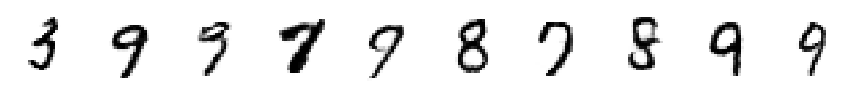

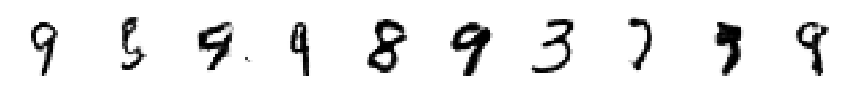

In [ ]:
for i in range(10):
  model.plot_generated()

# Example 2

In [ ]:
model_2 = GAN_model(summary=True, clear_session=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 3136)              630336    
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 64)       36928     
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 32)       18464     
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 56, 56, 16)       4624      
 ranspose)                                                       
                                                        

Epochs: 200
Batch size: 500
Batches per epoch: 120


  0%|          | 0/200 [00:00<?, ?it/s]

--------------- Epoch 1 ---------------


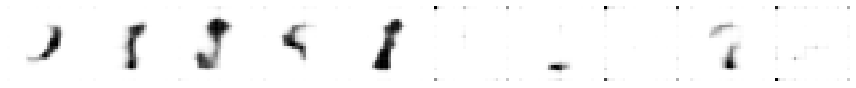

  2%|▏         | 4/200 [01:28<1:11:54, 22.01s/it]

--------------- Epoch 5 ---------------


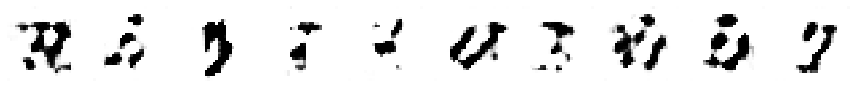

  4%|▍         | 9/200 [03:17<1:09:13, 21.75s/it]

--------------- Epoch 10 ---------------


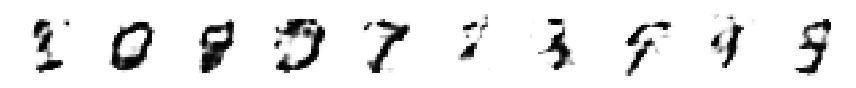

  7%|▋         | 14/200 [05:06<1:07:15, 21.70s/it]

--------------- Epoch 15 ---------------


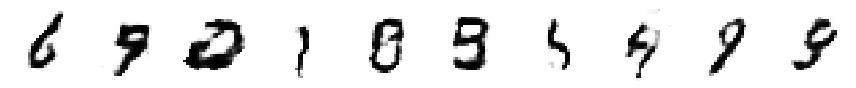

 10%|▉         | 19/200 [06:55<1:05:37, 21.76s/it]

--------------- Epoch 20 ---------------


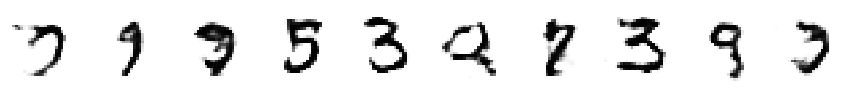

 12%|█▏        | 24/200 [08:44<1:03:56, 21.80s/it]

--------------- Epoch 25 ---------------


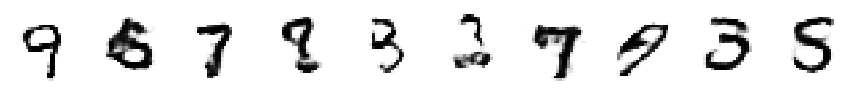

 14%|█▍        | 29/200 [10:35<1:02:49, 22.05s/it]

--------------- Epoch 30 ---------------


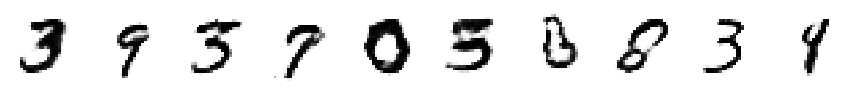

 17%|█▋        | 34/200 [12:25<1:00:36, 21.91s/it]

--------------- Epoch 35 ---------------


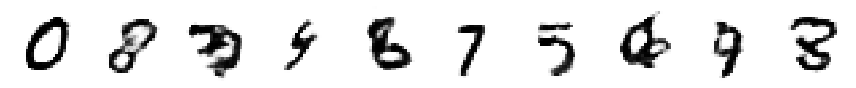

 20%|█▉        | 39/200 [14:13<58:21, 21.75s/it]

--------------- Epoch 40 ---------------


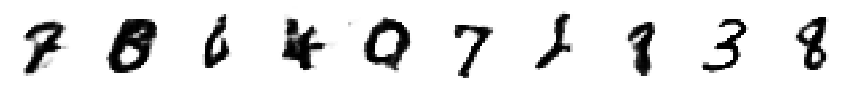

 22%|██▏       | 44/200 [16:02<56:17, 21.65s/it]

--------------- Epoch 45 ---------------


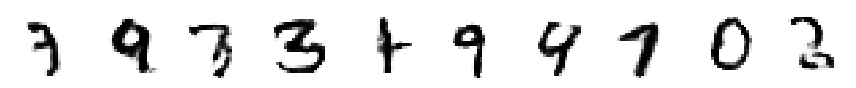

 24%|██▍       | 49/200 [17:51<55:02, 21.87s/it]

--------------- Epoch 50 ---------------


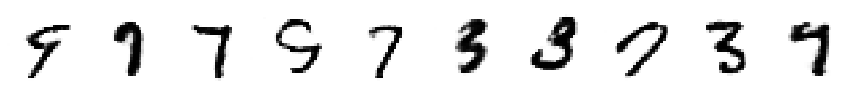

 27%|██▋       | 54/200 [19:40<53:02, 21.79s/it]

--------------- Epoch 55 ---------------


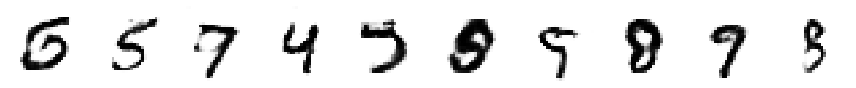

 30%|██▉       | 59/200 [21:29<51:07, 21.75s/it]

--------------- Epoch 60 ---------------


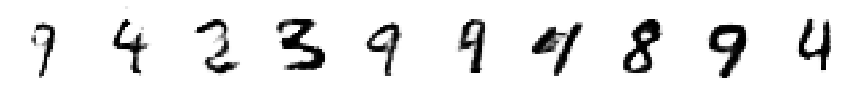

 32%|███▏      | 64/200 [23:18<49:03, 21.64s/it]

--------------- Epoch 65 ---------------


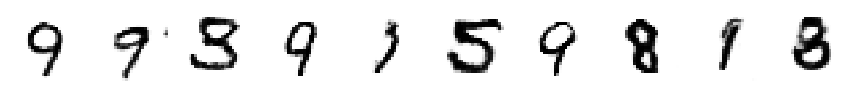

 34%|███▍      | 69/200 [25:06<47:07, 21.58s/it]

--------------- Epoch 70 ---------------


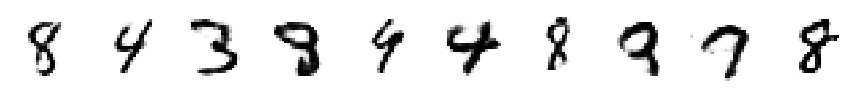

 37%|███▋      | 74/200 [26:55<45:40, 21.75s/it]

--------------- Epoch 75 ---------------


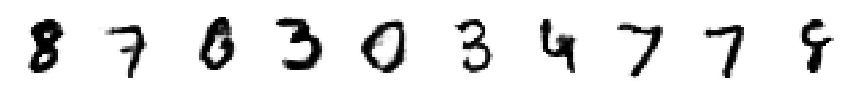

 40%|███▉      | 79/200 [28:43<43:38, 21.64s/it]

--------------- Epoch 80 ---------------


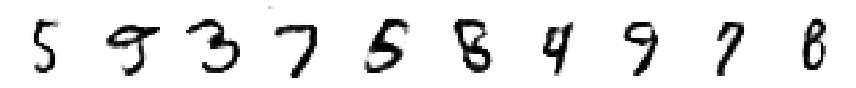

 42%|████▏     | 84/200 [30:32<41:54, 21.67s/it]

--------------- Epoch 85 ---------------


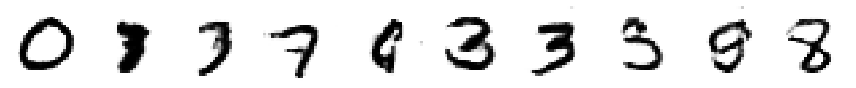

 44%|████▍     | 89/200 [32:20<39:52, 21.56s/it]

--------------- Epoch 90 ---------------


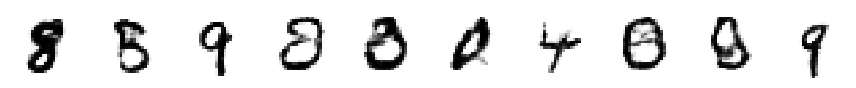

 47%|████▋     | 94/200 [34:08<38:11, 21.62s/it]

--------------- Epoch 95 ---------------


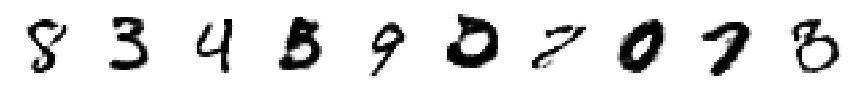

 50%|████▉     | 99/200 [35:56<36:23, 21.62s/it]

--------------- Epoch 100 ---------------


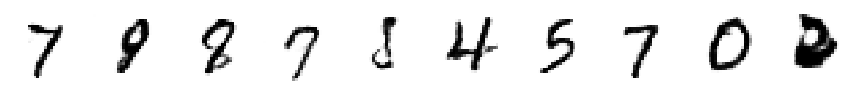

 52%|█████▏    | 104/200 [37:44<34:28, 21.55s/it]

--------------- Epoch 105 ---------------


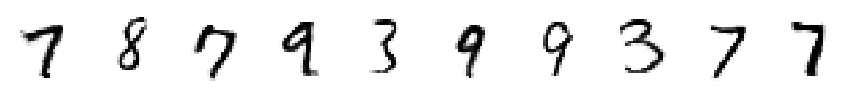

 55%|█████▍    | 109/200 [39:32<32:38, 21.53s/it]

--------------- Epoch 110 ---------------


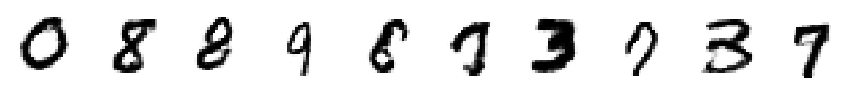

 57%|█████▋    | 114/200 [41:21<31:09, 21.74s/it]

--------------- Epoch 115 ---------------


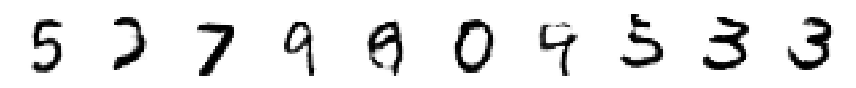

 60%|█████▉    | 119/200 [43:10<29:23, 21.78s/it]

--------------- Epoch 120 ---------------


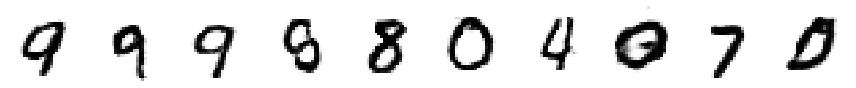

 62%|██████▏   | 124/200 [44:58<27:16, 21.54s/it]

--------------- Epoch 125 ---------------


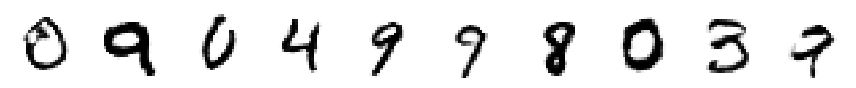

 64%|██████▍   | 129/200 [46:46<25:30, 21.56s/it]

--------------- Epoch 130 ---------------


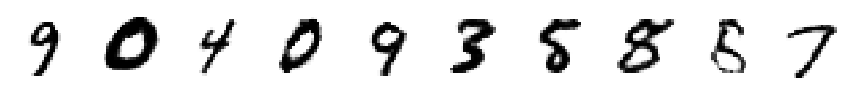

 67%|██████▋   | 134/200 [48:34<23:54, 21.73s/it]

--------------- Epoch 135 ---------------


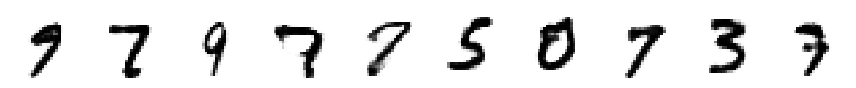

 70%|██████▉   | 139/200 [50:23<22:01, 21.66s/it]

--------------- Epoch 140 ---------------


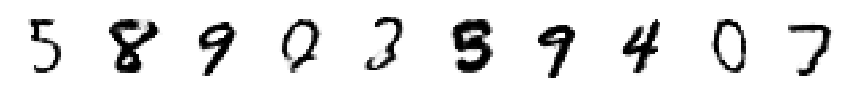

 72%|███████▏  | 144/200 [52:11<20:07, 21.56s/it]

--------------- Epoch 145 ---------------


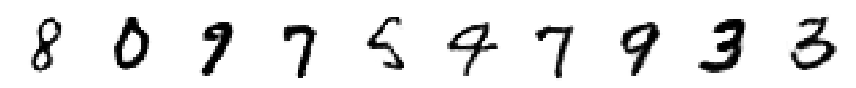

 74%|███████▍  | 149/200 [53:58<18:17, 21.52s/it]

--------------- Epoch 150 ---------------


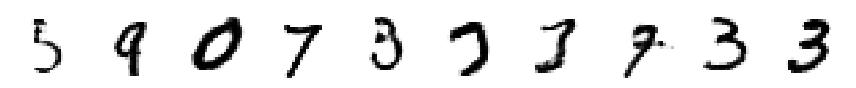

 77%|███████▋  | 154/200 [55:46<16:30, 21.53s/it]

--------------- Epoch 155 ---------------


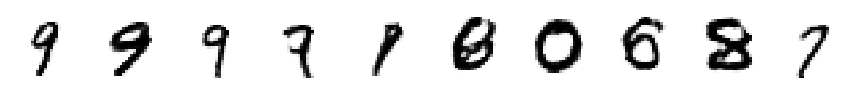

 80%|███████▉  | 159/200 [57:33<14:40, 21.47s/it]

--------------- Epoch 160 ---------------


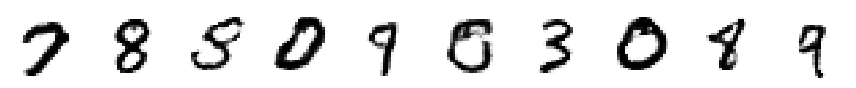

 82%|████████▏ | 164/200 [59:20<12:49, 21.38s/it]

--------------- Epoch 165 ---------------


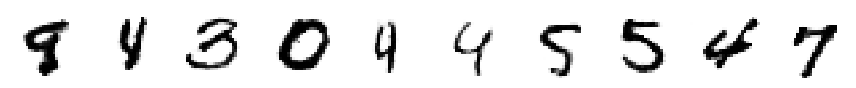

 84%|████████▍ | 169/200 [1:01:08<11:07, 21.52s/it]

--------------- Epoch 170 ---------------


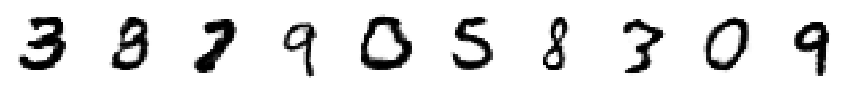

 87%|████████▋ | 174/200 [1:02:55<09:14, 21.34s/it]

--------------- Epoch 175 ---------------


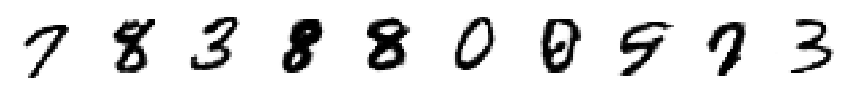

 90%|████████▉ | 179/200 [1:04:43<07:30, 21.47s/it]

--------------- Epoch 180 ---------------


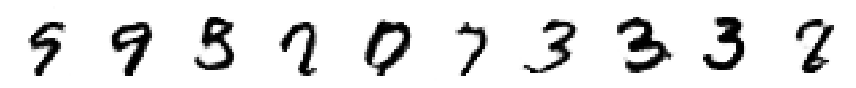

 92%|█████████▏| 184/200 [1:06:31<05:43, 21.47s/it]

--------------- Epoch 185 ---------------


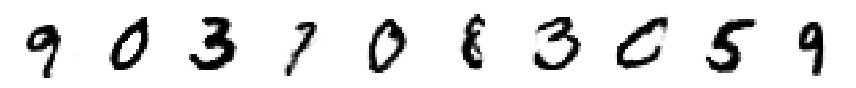

 94%|█████████▍| 189/200 [1:08:18<03:55, 21.40s/it]

--------------- Epoch 190 ---------------


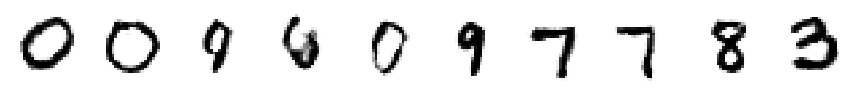

 97%|█████████▋| 194/200 [1:10:05<02:08, 21.48s/it]

--------------- Epoch 195 ---------------


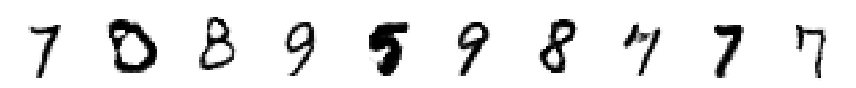

100%|█████████▉| 199/200 [1:11:54<00:21, 21.58s/it]

--------------- Epoch 200 ---------------


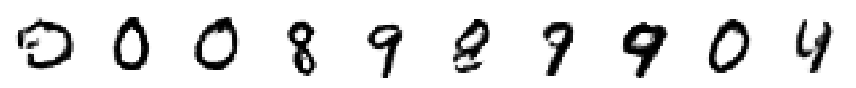

100%|██████████| 200/200 [1:12:15<00:00, 21.68s/it]


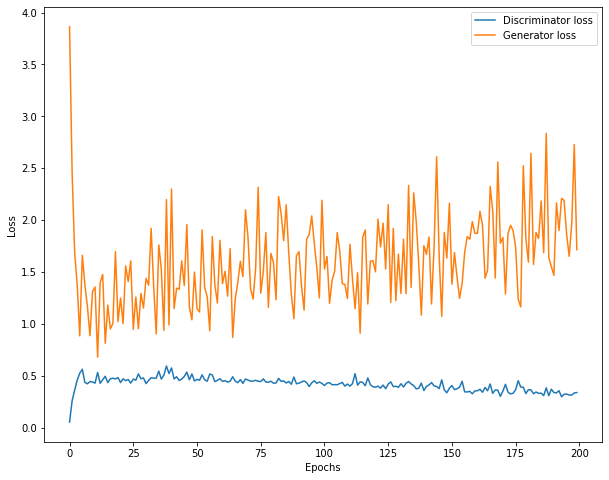

In [ ]:
model_2.fit(x_train/255, epochs=200, freq=5)

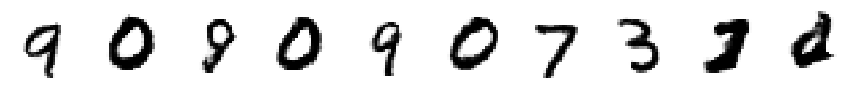

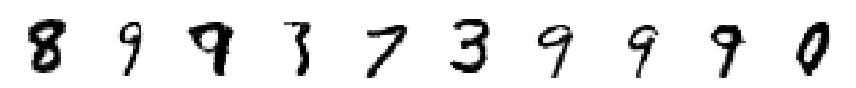

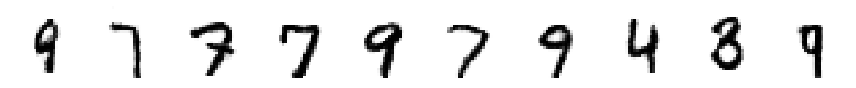

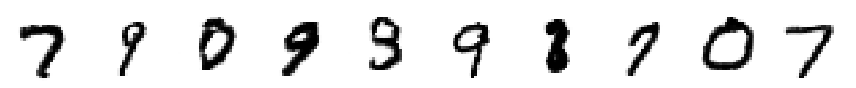

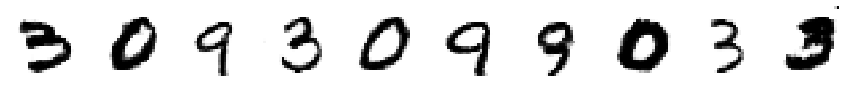

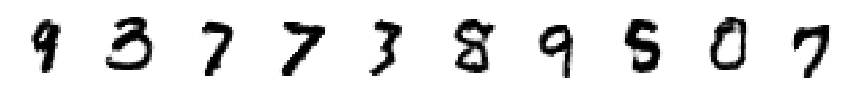

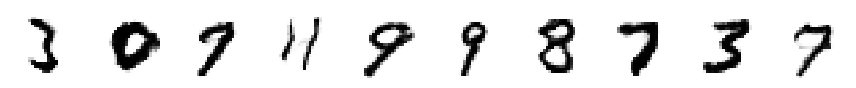

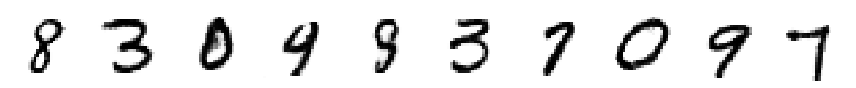

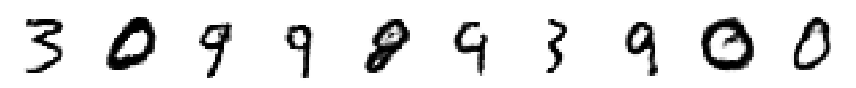

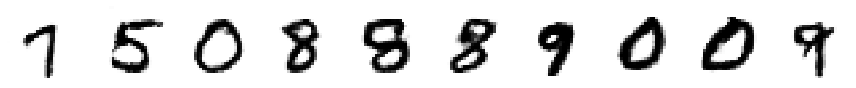

In [ ]:
for i in range(10):
  model_2.plot_generated()

## Evaluate

In [ ]:
# take real images
real_X = x_train[np.random.randint(0, x_train.shape[0], size=500)]
# noise
noise_X = np.random.normal(0, 1, size=(500, 200))
# generate fake image
fake_X = model_2.generator.predict(noise_X)

y_real = np.ones((500, 1))
y_fake = np.zeros((500, 1))

summarize_performance(model_2, real_X, y_real, fake_X, y_fake)

>>> Accuracy real: 100%, fake: 85%
